# Project 3 - Solving PDEs using Physics Informed Neural Networks (PINNs)
## Grid search for hyperparameter settings
This notebook shows a selection of grid searches and randomized grid searches done for with the PINN-implementation based on ...


### Notebook initial imports and defaults

In [64]:
from networkFlow import *
from PDEq import *
from support import *

import autograd.numpy as anp
import numpy as np
from math import log10

import matplotlib.pyplot as plt

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (6,3); plt.rcParams["font.size"] = 10
cmap = 'hot_r'; bin_vals = 7

## --- Network initial defaults --- ##
## Collocation tensor parameters
c_points = 1000; b_points = 20; i_points = 20

## Activation function
hidden_func = 'swish' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential

## Layer configuration
l_size = 20; 
layer_out_sizes = [20,20,1]

act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)

## Output layer activation function set to identity
act_funcs.append(None); 

## Training parameters
epoch = 1000
gd_method = 'adam'

## --- Search parameters --- ##
num = 6
rand_num = 50

## --- Problem setup --- ##
## Differential equations
test_cases = ['diff1d','wave1d','wave2d','diff2d']
test = test_cases[1]

## Coefficients
c,D,amplitude = 0.7,0.1,0.2

if test == 'diff1d':
    PDE = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'wave2d':
    PDE = Wave2D(sim_type='flow',amp=amplitude,c=c)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1
elif test == 'diff2d':
    PDE = Diffusion2D(sim_type='flow',amp=amplitude,D=D)
    t0,tN = 0,1
    x0,xN,y0,yN = 0,1,0,1

## Defining the source function
f = PDE.right_hand_side

## Domain setup
Nt,Nx,Ny = 100,100,100

t_bound = [t0,tN]
x_bound = [x0,xN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)

if test == 'wave2d' or test == 'diff2d':
    y_bound = [y0,yN]
    y = np.linspace(y_bound[0],y_bound[1],Ny)
    domain_array = np.array([t,x,y])
else:
    domain_array = np.array([t,x])

## Regular grid search 
### Learning rate, $\eta$, vs. regularization, $\lambda$
A grid search comparing the learning rate and regularization of the parameters of the network. Here, gradient descent is performed using the `Adagrad`-method.

In [65]:
## Training parameters
eta = np.logspace(-3,-1,num)
lmbda = np.logspace(-9,-7,num)

cost = np.zeros((len(eta),len(lmbda)))

for i in range(len(eta)):
    for j in range(len(lmbda)):
        ## Network initializtion
        if test == 'wave2d' or test == 'diff2d':
            TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta[i])

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
        else:
            TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta[i])

            ## Setup of collocation tensor
            TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

        TFNetwork.create_layers(lmbda=lmbda[j])

        print('η,λ = %.2e, %.2e' %(eta[i],lmbda[j]))
        TFNetwork.train_network(epochs=epoch)

        cost[i,j] = TFNetwork.cost_history[-1]

η,λ = 1.00e-03, 1.00e-09
Final cost = 6.27600e-04
η,λ = 1.00e-03, 2.51e-09
Final cost = 8.40607e-04
η,λ = 1.00e-03, 6.31e-09
Final cost = 1.03090e-03
η,λ = 1.00e-03, 1.58e-08
Final cost = 1.28843e-03
η,λ = 1.00e-03, 3.98e-08
Final cost = 4.34417e-04
η,λ = 1.00e-03, 1.00e-07
Final cost = 6.83980e-04
η,λ = 2.51e-03, 1.00e-09
Final cost = 3.57449e-04
η,λ = 2.51e-03, 2.51e-09
Final cost = 1.33030e-04
η,λ = 2.51e-03, 6.31e-09
Final cost = 3.20819e-04
η,λ = 2.51e-03, 1.58e-08
Final cost = 2.89333e-04
η,λ = 2.51e-03, 3.98e-08
Final cost = 1.41419e-04
η,λ = 2.51e-03, 1.00e-07
Final cost = 1.64658e-04
η,λ = 6.31e-03, 1.00e-09
Final cost = 2.21655e-04
η,λ = 6.31e-03, 2.51e-09
Final cost = 2.02043e-04
η,λ = 6.31e-03, 6.31e-09
Final cost = 1.35570e-03
η,λ = 6.31e-03, 1.58e-08
Final cost = 1.65663e-04
η,λ = 6.31e-03, 3.98e-08
Final cost = 3.68608e-04
η,λ = 6.31e-03, 1.00e-07
Final cost = 9.22754e-05
η,λ = 1.58e-02, 1.00e-09
Final cost = 3.56595e-05
η,λ = 1.58e-02, 2.51e-09
Final cost = 1.72513e-04


Min cost for:
η = 1.000e-01
λ = 2.512e-09
Final cost = 6.74315e-06


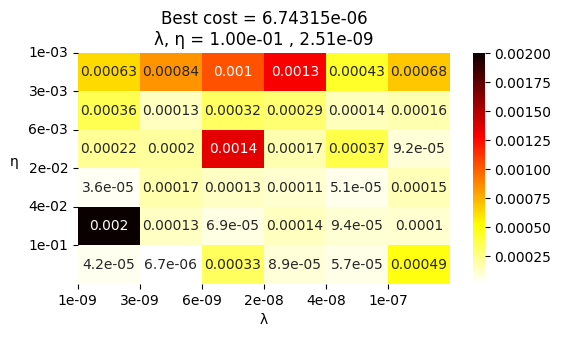

In [68]:
fig,ax = lambda_eta(cost,[lmbda,eta],
                    axis_tick_labels=[[f'{y:.0e}' for y in lmbda],[f'{y:.0e}' for y in eta]],
                    cbar_lim=[cost.min(),cost.max()],cmap=cmap
                    )

fig.set_size_inches(6,3)

min_cost_idx = np.argmin(cost); min_cost_pos = np.unravel_index(min_cost_idx, cost.shape)
ax.set_title('Best cost = %.5e\nλ, η = %.2e , %.2e' %(cost[min_cost_pos],eta[min_cost_pos[0]],lmbda[min_cost_pos[1]]))

print('Min cost for:\nη = %.3e\nλ = %.3e'%(eta[min_cost_pos[0]],lmbda[min_cost_pos[1]]))
print('Final cost = %.5e' %cost[min_cost_pos])

## Randomized grid searchs
The following part performs a randomized grid search for the optimal hyperparameters for the chosen PDE-problem. 

It does searches of random combinations of learning rate, $\eta$, regularization, $\lambda$, epochs, $e$, network depth, $d$, and hidden layer width, $M$. 

The ranges currently set up in the cells below are ranges that was found to give good results for the chosen PDE-problem.
### Search: Learning rate, $\eta$, vs. regularization, $\lambda$

In [10]:
## Search parameters
eta_range = [1e-3,1e-1]
lmbda_range = [1e-9,1e-7]

cost = np.zeros(rand_num)
etas = np.zeros_like(cost)
lmbdas = np.zeros_like(etas)

for i in range(rand_num):
    ## Picking parameters from uniform distribution
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    lmbda = 10 ** np.random.uniform(log10(lmbda_range[0]), log10(lmbda_range[1])); lmbdas[i] = lmbda
    
    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, λ = %.2e, %.2e' %(eta,lmbda))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, λ = 4.98e-02, 2.28e-09
Final cost = 2.85774e-05
η, λ = 5.29e-03, 3.55e-09
Final cost = 1.99372e-04
η, λ = 4.09e-03, 4.06e-09
Final cost = 2.25906e-04
η, λ = 3.16e-03, 6.84e-08
Final cost = 1.82473e-04
η, λ = 2.73e-02, 5.39e-08
Final cost = 2.70907e-04
η, λ = 2.64e-03, 2.16e-09
Final cost = 1.49350e-04
η, λ = 1.20e-03, 2.51e-09
Final cost = 6.59433e-04
η, λ = 3.30e-03, 1.50e-09
Final cost = 1.21413e-04
η, λ = 1.05e-02, 7.76e-08
Final cost = 4.01808e-04
η, λ = 9.02e-03, 4.92e-09
Final cost = 3.71498e-04
η, λ = 3.96e-03, 1.19e-08
Final cost = 4.65160e-05
η, λ = 4.39e-02, 5.18e-08
Final cost = 1.36856e-04
η, λ = 4.50e-02, 2.45e-08
Final cost = 8.24331e-05
η, λ = 6.04e-03, 6.49e-09
Final cost = 9.01432e-05
η, λ = 2.13e-02, 2.92e-08
Final cost = 5.32310e-05
η, λ = 2.13e-03, 9.27e-09
Final cost = 1.55769e-04
η, λ = 1.15e-03, 1.90e-08
Final cost = 4.55364e-04
η, λ = 1.27e-03, 4.79e-09
Final cost = 9.44986e-04
η, λ = 3.41e-02, 8.46e-09
Final cost = 1.17937e-04
η, λ = 3.48e-02, 3.83e-08
Final

Min cost for:
η = 1.899e-03
λ = 2.274e-08
Final cost = 1.92673e-06


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:394: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


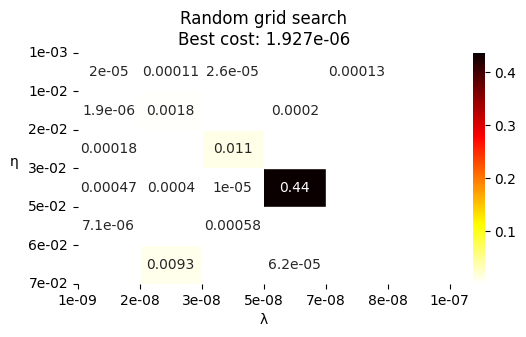

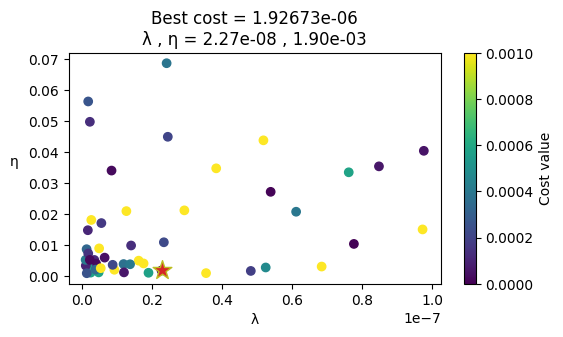

In [37]:
fig_h,ax_h = rand_heatmap(cost,[lmbdas,etas],
             axis_tick_labels='scientific',axis_labels=['λ','η'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),0.01]
             )

fig_s,ax_s = rand_scatter(cost,[lmbdas,etas],axis_labels=['λ','η'],cmap='viridis',cbar_lim=[0.,0.001])

fig_h.set_size_inches(6,3)
fig_s.set_size_inches(6,3) 

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nλ = %.3e'%(etas[min_cost_idx],lmbdas[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Network depth, $d$, vs. hidden layer size, $M$ 

In [38]:
## Restating training parameters
eta = 5e-2
lmbda = 2e-09

## Search parameters
d_range = [1,6]
M_range = [1,50]

cost = np.zeros(rand_num)
d = np.zeros(rand_num)
M = np.zeros(rand_num)

for i in range(rand_num):
    ## Setting random parameters
    l_size = np.random.randint(M_range[0],M_range[1]); M[i] = l_size
    num_lay = np.random.randint(d_range[0],d_range[1]); d[i] = num_lay
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('d, M = %i, %i' %(num_lay,l_size))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

d, M = 5, 1
Final cost = 6.45040e-03
d, M = 1, 4
Final cost = 1.20261e-03
d, M = 1, 27
Final cost = 6.06274e-04
d, M = 1, 17
Final cost = 8.00028e-04
d, M = 5, 38
Final cost = 4.06371e-03
d, M = 3, 21
Final cost = 1.21668e-04
d, M = 4, 27
Final cost = 8.83188e-05
d, M = 2, 44
Final cost = 1.51746e-04
d, M = 4, 21
Final cost = 1.83661e-04
d, M = 4, 31
Final cost = 5.61633e-05
d, M = 2, 41
Final cost = 1.63073e-04
d, M = 1, 12
Final cost = 4.34713e-04
d, M = 1, 12
Final cost = 6.81608e-04
d, M = 4, 40
Final cost = 5.34302e-03
d, M = 1, 12
Final cost = 7.44037e-04
d, M = 2, 38
Final cost = 2.25016e-04
d, M = 3, 8
Final cost = 1.17603e-05
d, M = 2, 21
Final cost = 2.00154e-04
d, M = 4, 18
Final cost = 1.79379e-04
d, M = 2, 31
Final cost = 3.26241e-04
d, M = 2, 35
Final cost = 5.22066e-03
d, M = 5, 31
Final cost = 1.83523e-04
d, M = 4, 8
Final cost = 1.11069e-04
d, M = 2, 38
Final cost = 1.50636e-04
d, M = 4, 14
Final cost = 8.86263e-05
d, M = 5, 46
Final cost = 6.74967e-03
d, M = 5, 43
Fin

Min cost for:
d = 5.000000
M = 16.000000
Final cost = 8.68065e-06


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:394: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


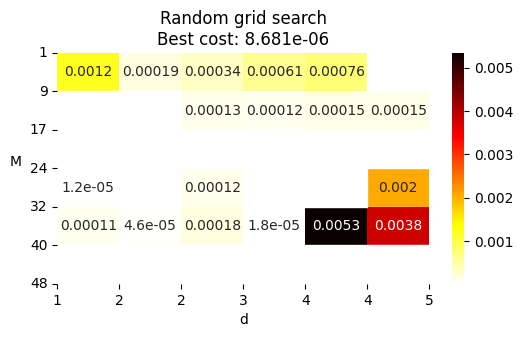

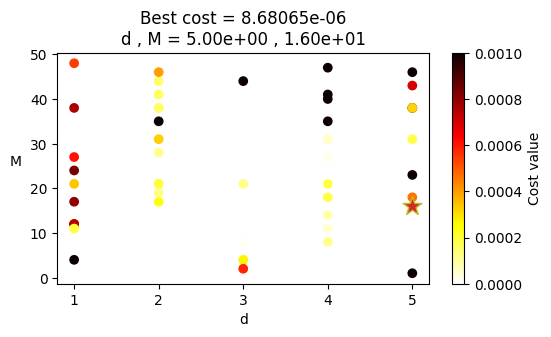

In [40]:
fig_h,ax_h = rand_heatmap(cost,[d,M],
             axis_tick_labels='float',axis_labels=['d','M'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[d,M],axis_labels=['d','M'],cmap=cmap,cbar_lim=[0.,0.001])

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4) 

min_cost_idx = cost.argmin()
print('Min cost for:\nd = %f\nM = %f'%(d[min_cost_idx],M[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Learning rate, $\eta$, vs. number of epochs, $e$

In [41]:
## Restating network structure parameters
layer_out_sizes = [20,20,1]
act_funcs = []
for i in range(len(layer_out_sizes)-1):
    act_funcs.append(hidden_func)
act_funcs.append(None)

## Search parameters
eta_range = [1e-3,1e-1]
epoch_range = [10,4000]

cost = np.zeros(rand_num)
etas = np.zeros_like(cost)
epochs = np.zeros_like(etas)

for i in range(rand_num):
    ## Picking random parameters
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    epoch = np.random.randint(epoch_range[0],epoch_range[1]); epochs[i] = epoch
    
    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, e = %.3e, %i' %(eta,epoch))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, e = 2.355e-02, 2472
Final cost = 1.39408e-06
η, e = 2.182e-02, 1412
Final cost = 9.42970e-05
η, e = 4.234e-02, 2707
Final cost = 1.04709e-05
η, e = 6.835e-03, 2800
Final cost = 1.64350e-06
η, e = 3.165e-03, 862
Final cost = 5.33564e-04
η, e = 1.032e-03, 2057
Final cost = 5.71370e-05
η, e = 1.863e-03, 2813
Final cost = 1.06015e-04
η, e = 1.218e-03, 629
Final cost = 1.00267e-03
η, e = 1.714e-02, 1142
Final cost = 1.57074e-05
η, e = 1.427e-03, 672
Final cost = 3.58315e-03
η, e = 2.634e-03, 1747
Final cost = 1.35202e-04
η, e = 8.384e-02, 1070
Final cost = 4.46660e-05
η, e = 3.352e-03, 1038
Final cost = 3.19567e-04
η, e = 5.599e-02, 501
Final cost = 1.35672e-03
η, e = 2.610e-02, 854
Final cost = 1.19115e-04
η, e = 2.485e-02, 177
Final cost = 1.07753e-03
η, e = 1.162e-02, 485
Final cost = 4.09703e-04
η, e = 5.569e-02, 1844
Final cost = 1.02743e-05
η, e = 8.900e-02, 3129
Final cost = 1.52416e-05
η, e = 4.147e-03, 1961
Final cost = 1.01210e-05
η, e = 1.116e-03, 926
Final cost = 5.07058e-04


Min cost for:
η = 2.355e-02
e = 2472
Final cost = 1.39408e-06


/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:394: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


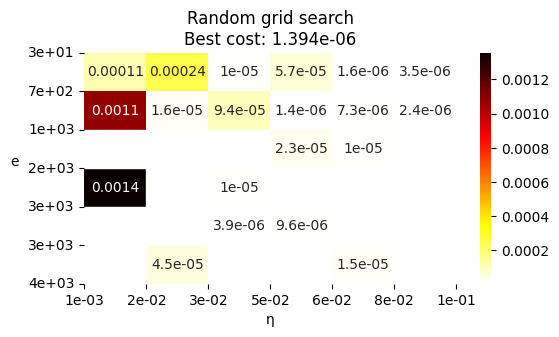

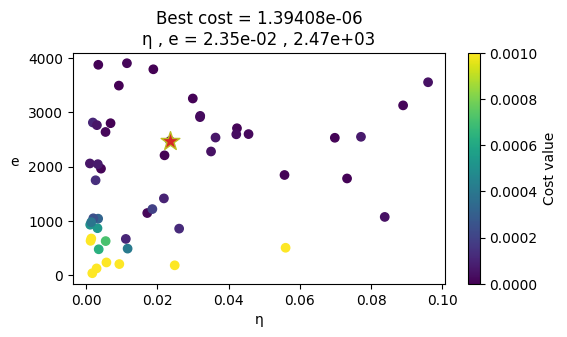

In [49]:
fig_h,ax_h = rand_heatmap(cost,[etas,epochs],
             axis_tick_labels='scientific',axis_labels=['η','e'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,epochs],axis_labels=['η','e'],cbar_lim=[0.,0.001],cmap='viridis')

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\ne = %i'%(etas[min_cost_idx],epochs[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

### Search: Learning rate, $\eta$ vs., network depth, $d$

In [50]:
## Restating training parameters
epoch = 2000

## Search parameters
eta_range = [1e-3,1e-1]
d_range = [1,6]

cost = np.zeros(rand_num)
etas = np.zeros(rand_num)
d = np.zeros(rand_num)

for i in range(rand_num):
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta

    num_lay = np.random.randint(d_range[0],d_range[1]); d[i] = num_lay
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)

    ## Output layer activation function set to identity
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, d = %.3e, %i' %(eta,num_lay))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, d = 2.463e-02, 1
Final cost = 1.38811e-04
η, d = 4.480e-03, 4
Final cost = 1.55552e-04
η, d = 2.515e-02, 3
Final cost = 2.45258e-05
η, d = 1.823e-02, 4
Final cost = 6.19694e-05
η, d = 6.813e-03, 1
Final cost = 2.30854e-04
η, d = 1.219e-03, 4
Final cost = 3.35197e-04
η, d = 1.840e-02, 2
Final cost = 1.19662e-05
η, d = 3.925e-03, 4
Final cost = 1.56257e-04
η, d = 1.681e-03, 2
Final cost = 5.40283e-04
η, d = 5.231e-03, 2
Final cost = 1.34818e-04
η, d = 4.438e-02, 2
Final cost = 2.59049e-05
η, d = 3.938e-02, 4
Final cost = 2.04912e-04
η, d = 2.843e-02, 5
Final cost = 1.40142e-05
η, d = 1.113e-03, 2
Final cost = 1.45177e-05
η, d = 6.524e-02, 5
Final cost = 5.79191e-04
η, d = 5.904e-03, 5
Final cost = 5.71475e-05
η, d = 1.246e-03, 4
Final cost = 1.39735e-04
η, d = 1.358e-03, 1
Final cost = 2.94206e-04
η, d = 9.439e-02, 2
Final cost = 8.05163e-05
η, d = 2.110e-02, 3
Final cost = 4.38030e-06
η, d = 2.727e-02, 3
Final cost = 5.25404e-05
η, d = 1.007e-03, 1
Final cost = 8.70198e-04
η, d = 6.2

/home/anders_tb/02-uio/fysstk4155/project-3-fys-stk4155/01-main/support.py:394: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color='1', edgecolor='none'))


Min cost for:
η = 2.110e-02
d = 3
Final cost = 4.38030e-06


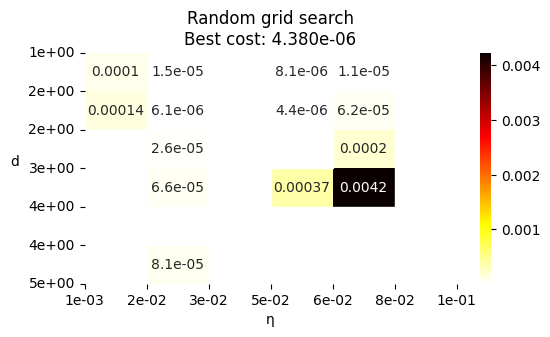

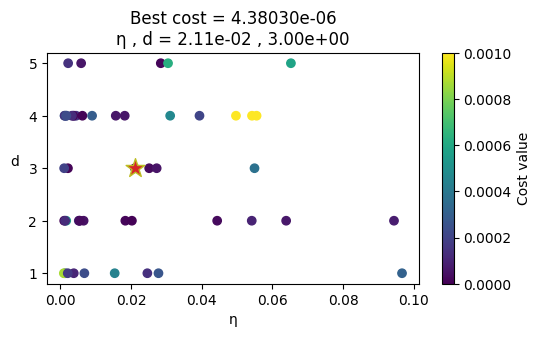

In [56]:
fig_h,ax_h = rand_heatmap(cost,[etas,d],
             axis_tick_labels='scientific',axis_labels=['η','d'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,d],cmap='viridis', #cmap,
                          cbar_lim=[0.,0.001],axis_labels=['η','d'])

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4)

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nd = %i'%(etas[min_cost_idx],d[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])


### Search: Learning rate, $\eta$ vs. hidden layer width, $M$

In [58]:
## Restating network parameters
num_lay = 4; epoch = 1500

## Search parameters
eta_range = [1e-3,1e-1]
M_range = [1,50]

cost = np.zeros(rand_num)
etas = np.zeros(rand_num)
M = np.zeros(rand_num)

for i in range(rand_num):
    ## Picking random parameters
    l_size = np.random.randint(M_range[0],M_range[1]); M[i] = l_size
    eta = 10 ** np.random.uniform(log10(eta_range[0]), log10(eta_range[1])); etas[i] = eta
    
    act_funcs = []; layer_out_sizes = [1]
    for _ in range(num_lay):
        layer_out_sizes = [l_size] + layer_out_sizes
        act_funcs.append(hidden_func)
    act_funcs.append(None); 

    ## Network initializtion
    if test == 'wave2d' or test == 'diff2d':
        TFNetwork = FFNNetworkFlow2D(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs,
                           PDE=PDE,
                           source_function=f,
                           domain_array=domain_array,
                           domain=[x_bound,y_bound],
                           gd_method=gd_method,
                           learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(t_bound,x_bound,y_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
    else:
        TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                            activation_functions=act_funcs,
                            PDE=PDE,
                            source_function=f,
                            domain_array=domain_array,
                            domain=x_bound,
                            gd_method=gd_method,
                            learning_rate=eta)

        ## Setup of collocation tensor
        TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                                    bound_points=b_points, init_points=i_points,
                                    plot_colloc=False)

    TFNetwork.create_layers(lmbda=lmbda)

    print('η, M = %.3e, %i' %(eta,l_size))
    TFNetwork.train_network(epochs=epoch)

    #cost.append(TFNetwork.cost_history[-1])
    cost[i] = TFNetwork.cost_history[-1]

η, M = 1.095e-03, 14
Final cost = 1.80442e-04
η, M = 1.327e-02, 10
Final cost = 4.45307e-05
η, M = 1.954e-03, 30
Final cost = 9.57697e-05
η, M = 3.583e-03, 32
Final cost = 4.29564e-04
η, M = 3.085e-03, 45
Final cost = 2.19529e-04
η, M = 9.033e-03, 12
Final cost = 9.59789e-06
η, M = 1.567e-03, 9
Final cost = 3.51496e-05
η, M = 4.647e-03, 14
Final cost = 2.08173e-04
η, M = 6.835e-02, 17
Final cost = 2.51885e-04
η, M = 8.837e-03, 25
Final cost = 1.82461e-04
η, M = 4.522e-02, 36
Final cost = 2.16441e-05
η, M = 1.426e-03, 48
Final cost = 6.81689e-04
η, M = 4.577e-02, 24
Final cost = 1.69753e-05
η, M = 3.234e-02, 28
Final cost = 7.61746e-04
η, M = 1.718e-03, 21
Final cost = 1.77086e-04
η, M = 1.615e-02, 17
Final cost = 6.26164e-05
η, M = 3.872e-02, 47
Final cost = 6.34123e-04
η, M = 4.917e-03, 6
Final cost = 7.70814e-06
η, M = 5.062e-03, 39
Final cost = 7.11075e-05
η, M = 4.910e-03, 49
Final cost = 1.38340e-04
η, M = 2.161e-03, 5
Final cost = 6.64520e-05
η, M = 2.953e-03, 39
Final cost = 3.4

In [69]:
fig_h,ax_h = rand_heatmap(cost,[etas,M],
             axis_tick_labels='',axis_labels=['η','M'],
             bin_vals=bin_vals,cmap=cmap,
             cbar_lim=[cost.min(),cost.max()]
             )

fig_s,ax_s = rand_scatter(cost,[etas,M],cmap=cmap,cbar_lim=[0.,0.0005],axis_labels=['η','M'])

#fig_h.set_size_inches(10,4)
#fig_s.set_size_inches(10,4) 

min_cost_idx = cost.argmin()
print('Min cost for:\nη = %.3e\nM = %i'%(etas[min_cost_idx],M[min_cost_idx]))
print('Final cost = %.5e' %cost[min_cost_idx])

IndexError: boolean index did not match indexed array along axis 0; size of axis is 6 but size of corresponding boolean axis is 50